# A. Visualisasi Keypoint SIFT

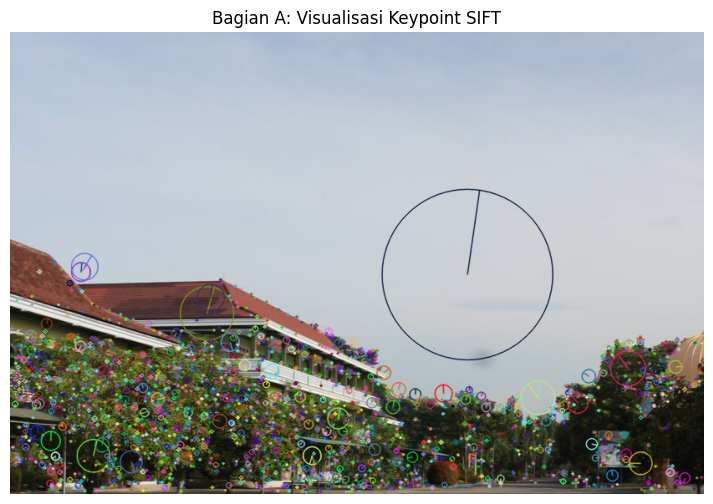

In [1]:
import cv2
import matplotlib.pyplot as plt

# Gunakan path sesuai struktur di Kaggle kamu
img_path = '/kaggle/input/jalan-unida/jalan 1.jpg' 
img = cv2.imread(img_path)

if img is None:
    print("Gambar tidak ditemukan! Pastikan nama dataset dan filenya sudah benar.")
else:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Inisialisasi SIFT
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    # Visualisasi keypoint dengan skala dan orientasi
    img_kp = cv2.drawKeypoints(
        img_rgb, 
        keypoints, 
        None, 
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    plt.figure(figsize=(10, 6))
    plt.imshow(img_kp)
    plt.title("Bagian A: Visualisasi Keypoint SIFT")
    plt.axis('off')
    plt.show()

# B. Scale Space dan Difference of Gaussian

<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_24/999369053.py:26: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'Blur $\sigma$ ({sigma})')
/tmp/ipykernel_24/999369053.py:31: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'Blur $k\sigma$ ({sigma*k:.1f})')


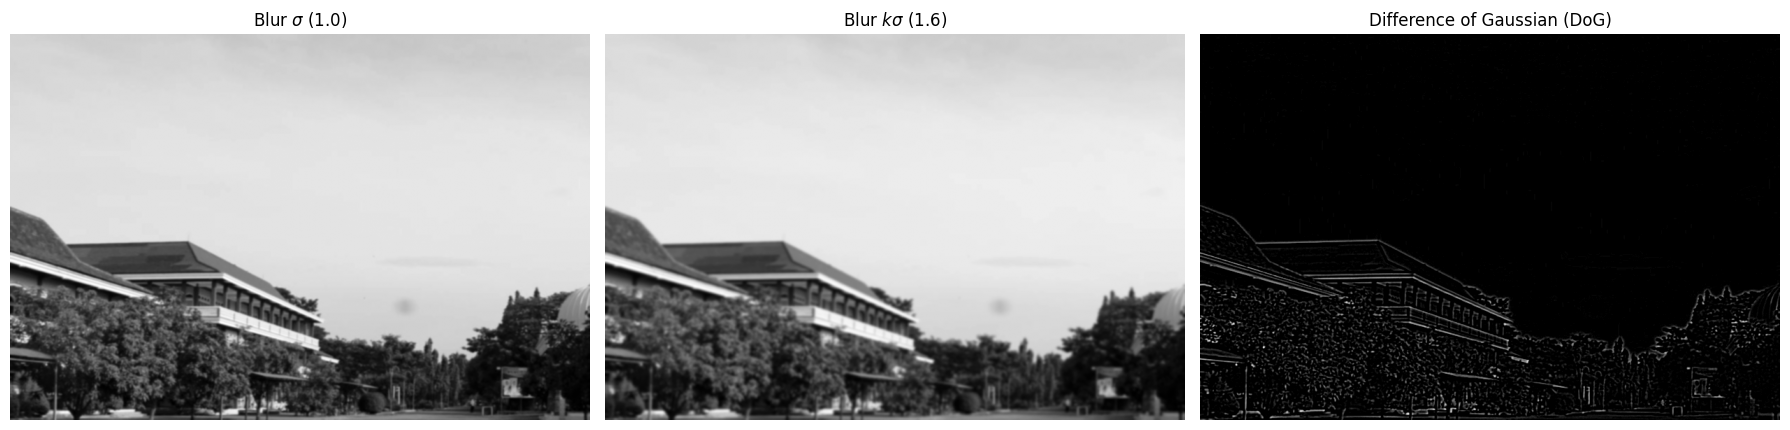

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 1. Muat citra (kita gunakan 'jalan 1.JPG' lagi)
img_path = '/kaggle/input/jalan-unida/jalan 1.jpg'
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Terapkan Gaussian Blur dengan dua nilai sigma (σ) berbeda
# Sesuai instruksi: satu σ dan satu lagi kσ (misal k=1.6) [cite: 31]
sigma = 1.0
k = 1.6
blur_sigma = cv2.GaussianBlur(gray, (0, 0), sigma)
blur_ksigma = cv2.GaussianBlur(gray, (0, 0), sigma * k)

# 3. Hitung Difference of Gaussian (DoG) 
# Mengurangi hasil blur satu dengan yang lain
dog = cv2.subtract(blur_sigma, blur_ksigma)

# 4. Tampilkan dalam satu tampilan (3 panel) [cite: 33, 35]
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(blur_sigma, cmap='gray')
plt.title(f'Blur $\sigma$ ({sigma})')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(blur_ksigma, cmap='gray')
plt.title(f'Blur $k\sigma$ ({sigma*k:.1f})')
plt.axis('off')

plt.subplot(1, 3, 3)
# Menggunakan colormap 'jet' atau 'gray' agar perbedaan terlihat jelas
plt.imshow(dog, cmap='gray')
plt.title('Difference of Gaussian (DoG)')
plt.axis('off')

plt.tight_layout()
plt.show()

# C. Feature Matching

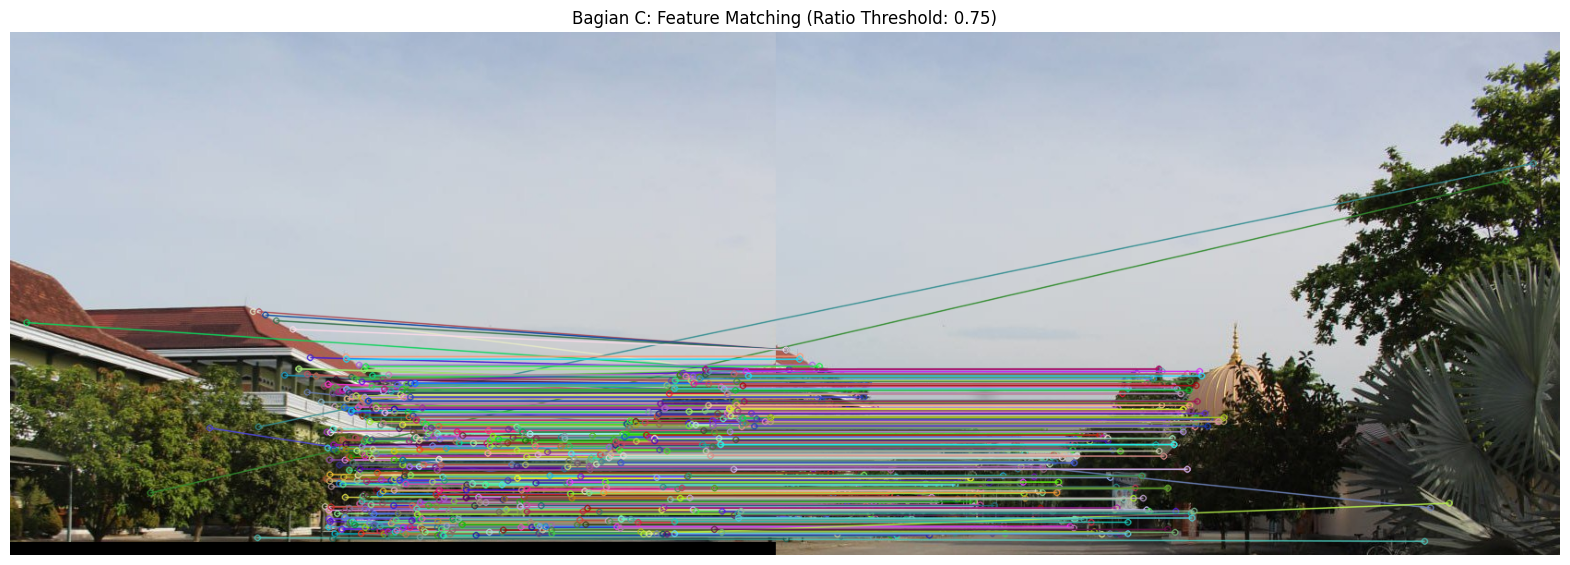

Jumlah kecocokan fitur yang baik: 604


In [3]:
import cv2
import matplotlib.pyplot as plt

# 1. Muat kedua citra berbeda dari dataset [cite: 41]
img1 = cv2.imread('/kaggle/input/jalan-unida/jalan 1.jpg')
img2 = cv2.imread('/kaggle/input/jalan-unida/jalan 2.jpg')

# Konversi ke Gray untuk proses SIFT
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 2. Deteksi keypoint dan descriptor menggunakan SIFT [cite: 42]
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# 3. Pencocokan fitur menggunakan BFMatcher [cite: 43]
# SIFT menggunakan desimal (L2 norm), jadi kita pakai NORM_L2
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# 4. Terapkan Lowe's ratio test 
good_matches = []
ratio_threshold = 0.75 # Kamu bisa coba ubah nilai ini (misal 0.5 atau 0.8)
for m, n in matches:
    if m.distance < ratio_threshold * n.distance:
        good_matches.append([m])

# 5. Visualisasikan garis-garis pencocokan fitur 
img_matches = cv2.drawMatchesKnn(
    img1, kp1, img2, kp2, good_matches, None, 
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title(f"Bagian C: Feature Matching (Ratio Threshold: {ratio_threshold})")
plt.axis('off')
plt.show()

print(f"Jumlah kecocokan fitur yang baik: {len(good_matches)}")

# D. Panorama Sederhana

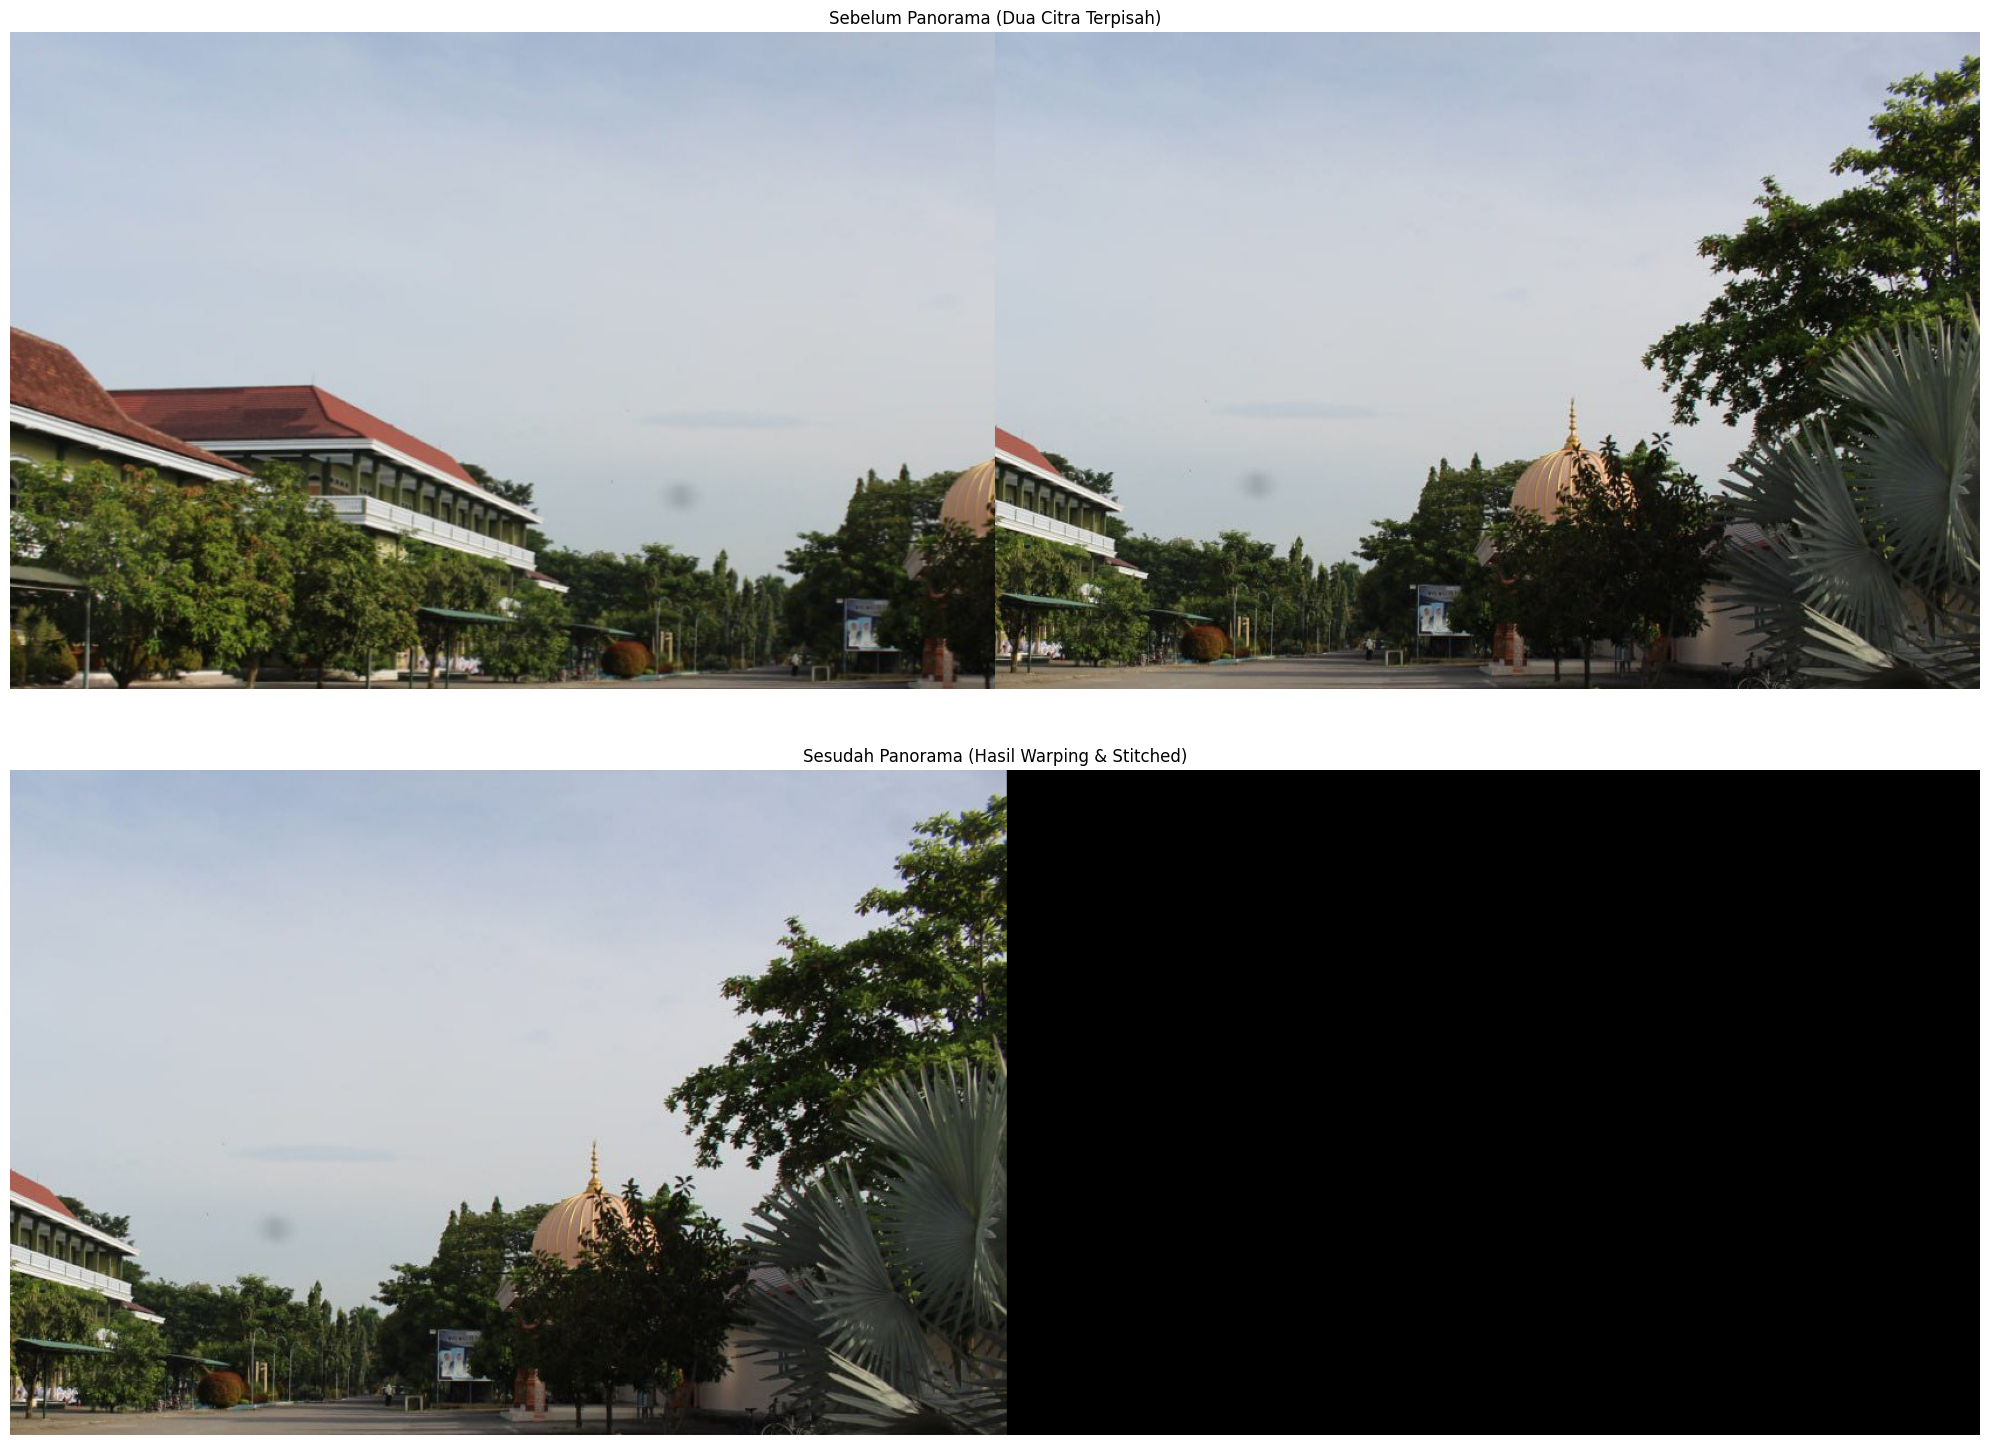

<Figure size 640x480 with 0 Axes>

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Bagian D: Panorama Sederhana ---

# 1. Ambil titik koordinat dari good_matches (Hasil Bagian C)
src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# 2. Hitung matriks Homografi menggunakan RANSAC sesuai instruksi [cite: 51]
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# 3. Warping dan Perluasan Kanvas [cite: 52]
# Perbaikan: Ambil tinggi maksimal dari kedua gambar agar tidak ValueError
height = max(img1.shape[0], img2.shape[0]) 
width = img1.shape[1] + img2.shape[1]

# Melakukan warping pada gambar pertama
img_warped = cv2.warpPerspective(img1, M, (width, height))

# 4. Membangun Panorama (Menempelkan citra kedua) [cite: 53]
img_panorama = img_warped.copy()
# Menempelkan img2 pada area awal kanvas
img_panorama[0:img2.shape[0], 0:img2.shape[1]] = img2

# --- Visualisasi Hasil (Sesuai yang harus dikumpulkan) [cite: 55] ---
plt.figure(figsize=(20, 15))

# Menampilkan citra SEBELUM panorama (berdampingan)
plt.subplot(2, 1, 1)
# Resize sementara hanya untuk visualisasi berdampingan agar rapi
img1_res = cv2.resize(img1, (img2.shape[1], img2.shape[0]))
combined_before = np.hstack((img1_res, img2))
plt.imshow(cv2.cvtColor(combined_before, cv2.COLOR_BGR2RGB))
plt.title("Sebelum Panorama (Dua Citra Terpisah)")
plt.axis('off')

# Menampilkan citra SESUDAH panorama
plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(img_panorama, cv2.COLOR_BGR2RGB))
plt.title("Sesudah Panorama (Hasil Warping & Stitched)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Simpan hasil untuk folder results/ 
plt.savefig('panorama_result.png', bbox_inches='tight')